<a href="https://colab.research.google.com/github/LukasEder1/DeepLearning/blob/main/Assignment2/exercise3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Cloud connection <- Nicht anfassen filip xD

In [133]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


# Assignment 2 - Exercise 3:
*   Improve the accuracy of the finetuned model
    *    Tune conv layers in addition to the fc layers
    *    Instead of replacing all fc layers, replace the last one
    *    Train for more epochs
    *    Try out different batch sizes, optimizers, learning rates
    *    Finetune a different network such as AlexNet or ResNet
*   Visualize filter (kernel) weights
*   Visualize activations

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models, utils
import matplotlib.pyplot as plt
import numpy as np
# To avoid the error URLError:<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed
import ssl
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Important Resize Iamges to 224, 224

In [27]:
# Output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create the data loaders for the train and test sets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# The 10 classes of CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


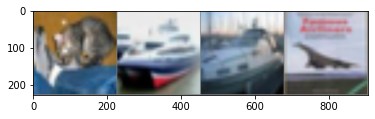

GroundTruth:    cat


In [38]:
# Check the testset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(1)))

## Finetuning

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#resnet

In [15]:

# Create a vgg16 network with pretrained weights (trained on ImageNet)
model_vgg16 = models.vgg16_bn(pretrained=True).to(device)
#model_res18 = models.resnet18(pretrained=True).to(device)

# Setup VGG16

In [17]:
# Prevent the trained weights from being modified
for param in model_vgg16.features.parameters():
    param.requires_grad = False

# Compute the input feature size for the first fc layer
num_ftrs = list(model_vgg16.classifier.children())[0].in_features
print(num_ftrs)

classifier = list(model_vgg16.classifier.children())[:-1] # Remove last layer
#classifier.extend([nn.Linear(num_ftrs, len(classes)).to(device)]) # Add our layer with 10 outputs

# Create a new set of fc layers
"""
classifier = [nn.Linear(in_features=num_ftrs, out_features=4096).to(device), 
              nn.ReLU(inplace=True).to(device), 
              nn.Dropout(p=0.5, inplace=False).to(device), 
              nn.Linear(in_features=4096, out_features=2048).to(device), 
              nn.ReLU(inplace=True).to(device), 
              nn.Dropout(p=0.5, inplace=False).to(device),
              nn.Linear(in_features=2048, out_features=1024).to(device), 
              nn.ReLU(inplace=True).to(device), 
              nn.Dropout(p=0.5, inplace=False).to(device),
              nn.Linear(in_features=1024, out_features=len(classes), bias=True).to(device)]


model_vgg16.classifier = nn.Sequential(*classifier) # Replace the model classifier
"""

#last
model_vgg16.classifier[6] = nn.Linear(4096, len(classes))

print(model_vgg16)

25088
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(12

Setup ResNEt

In [5]:
for param in model_res18.parameters():
    param.requires_grad = False

model_res18.fc = nn.Linear(512, len(classes))

In [29]:
summary(m.cuda(), (3, 32, 32)) # Input size: (channels, height, width of image)

RuntimeError: ignored

In [39]:
m = model_vgg16

In [40]:
# Define the loss and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(m.parameters(), lr=0.001, momentum=0.9)

In [41]:
m.train()
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = m(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.169
[1,  4000] loss: 0.882
[1,  6000] loss: 0.816
[1,  8000] loss: 0.776
[1, 10000] loss: 0.726
[1, 12000] loss: 0.699
[2,  2000] loss: 0.594
[2,  4000] loss: 0.603
[2,  6000] loss: 0.567
[2,  8000] loss: 0.566
[2, 10000] loss: 0.585
[2, 12000] loss: 0.567
Finished Training


Save Trained Model for future use cases

In [42]:
PATH = 'last_resized.pth'
torch.save(m.state_dict(), PATH)

In [43]:
%cp "/content/last_resized.pth" "/content/gdrive/MyDrive"

In [44]:
def load_model(path, mod):
    # Load the saved weights and create the network
    model = mod.to(device)
    model.load_state_dict(torch.load(PATH))
    
    return model

model = load_model("last_resized.pth", m)

# Evaluate the models accuracy

In [45]:
 # Check the accuracy of the finetuned network on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 77 %


# Visualize Kernels

Code taken from: https://stackoverflow.com/questions/55594969/how-to-visualise-filters-in-a-cnn-with-pytorch

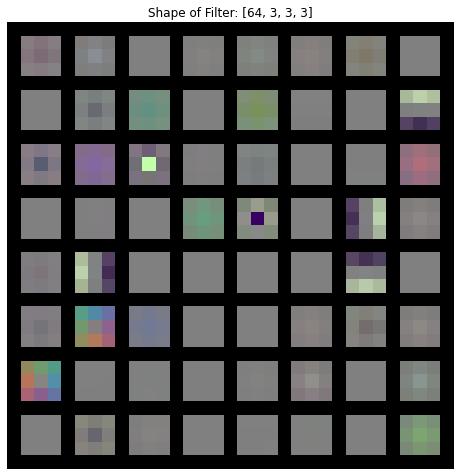

In [46]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
  n,c,w,h = tensor.shape

  if allkernels: tensor = tensor.view(n*c, -1, w, h)
  elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

  rows = np.min((tensor.shape[0] // nrow + 1, 64))    
  grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
  plt.figure( figsize=(nrow,rows) )
  plt.imshow(grid.numpy().transpose((1, 2, 0)))


model_children = list(model.children())
filter = model_children[0][0].weight.detach().clone().cpu()

visTensor(filter.cpu(), ch=0, allkernels=False)
shape = list(filter.shape)
plt.title(f"Shape of Filter: {shape}")
plt.axis('off')
plt.ioff()
plt.show()


# Visualize Activations (To-DO)